In [ ]:
from utils import draw_dot
import numpy as np

In [ ]:
class Node:
    def __init__(self, data, _children=(), label='', _op=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self.label = label
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), _op="+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __rtruediv__(self, other):
        return other * self**-1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data*other.data, (self, other), _op="*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        return self * other**-1
    
    def __pow__(self, other):
        out = Node(self.data**other, (self,), _op="**")

        def _backward():
            self.grad += (other * self.data ** (other- 1))*out.grad
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Node(np.maximum(self.data, 0), (self,), _op="RELU")

        def _backward():
            self.grad += out.grad if self.data > 0 else 0
        
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Node(np.tanh(self.data), (self,), _op="TANH")

        def _backward():
            self.grad += out.grad * (1 - np.tanh(self.data)**2)
        
        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and applb the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
            
    def __repr__(self):
        return f"Node(data={self.data})"
        
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    
    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, n_in, activation='relu'):
        self.w = [Node(np.random.uniform(-1,1), label=f'W{i+1}') for i in range(n_in)]
        self.b = Node(np.random.uniform(-1,1), label='Bias')
        self.activation = activation

    def __call__(self, x):
        #x = [Node(x_i,label=f'Input {i+1}') for i,x_i in enumerate(x)]
      
        if len(x) != len(self.w):
            raise ValueError(f"Input vector length {len(x)} does not match number of weights {len(self.w)}")

        out = np.sum(np.array(self.w)*np.array(x)) + self.b

        if self.activation == 'relu':
            return out.relu()
        elif self.activation == 'tanh':
            return out.tanh()
        
        return out

    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self) -> str:
        return f"Neuron( Weights:{[w.data for w in self.w]}, Bias:{self.b.data})"  
    
class Layer(Module):
    def __init__(self, n_in, n_out, activation='relu'):
        self.neurons = [Neuron(n_in, activation) for _ in range(n_out)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self) -> str:
        return f"Layer( {[neuron for neuron in self.neurons]})"
    
class MLP(Module):
    def __init__(self, n_in, n_outs, activation='relu'):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1], activation) for i in range(len(n_outs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self) -> str:
        return f"MLP( {[layer for layer in self.layers]})"

In [415]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
nn = MLP(3, [4, 4, 1], activation='tanh')

In [416]:
losses = []

for _ in range(20):
    # forward pass
    out = [nn(x) for x in xs]
    loss = np.sum(np.array(out) - np.array(ys))**2
    #loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(loss.data)
    losses.append(loss.data)

    nn.zero_grad()
    loss.backward()

    # update weights
    for p in nn.parameters():
        p.data += -0.01 * p.grad
    
    
print(f"Predictions: {out}")


7.932638716928951
1.890042911787487
0.05282126243033716
0.0052896519481378315
0.0005672795932099793
6.023258560341327e-05
6.424003956435563e-06
6.842322366992118e-07
7.291140466577347e-08
7.768276026592491e-09
8.27702721631065e-10
8.818960893378474e-11
9.3964247096333e-12
1.0011684283469963e-12
1.0667235574276194e-13
1.136570960444562e-14
1.2109919370877169e-15
1.2902857508316005e-16
1.374772041276091e-17
1.4647924282816506e-18
Predictions: [Node(data=-0.19530989449230296), Node(data=0.21238611602719115), Node(data=0.05511951859885676), Node(data=-0.07219574134403116)]


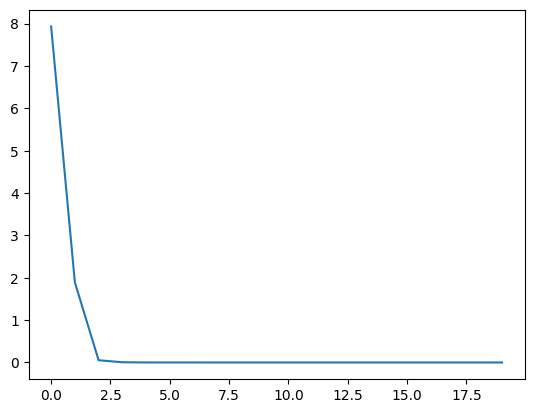

In [417]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0,20),losses)

In [340]:
print(out)

[Node(data=0.0), Node(data=0.0), Node(data=0.0), Node(data=0.0)]


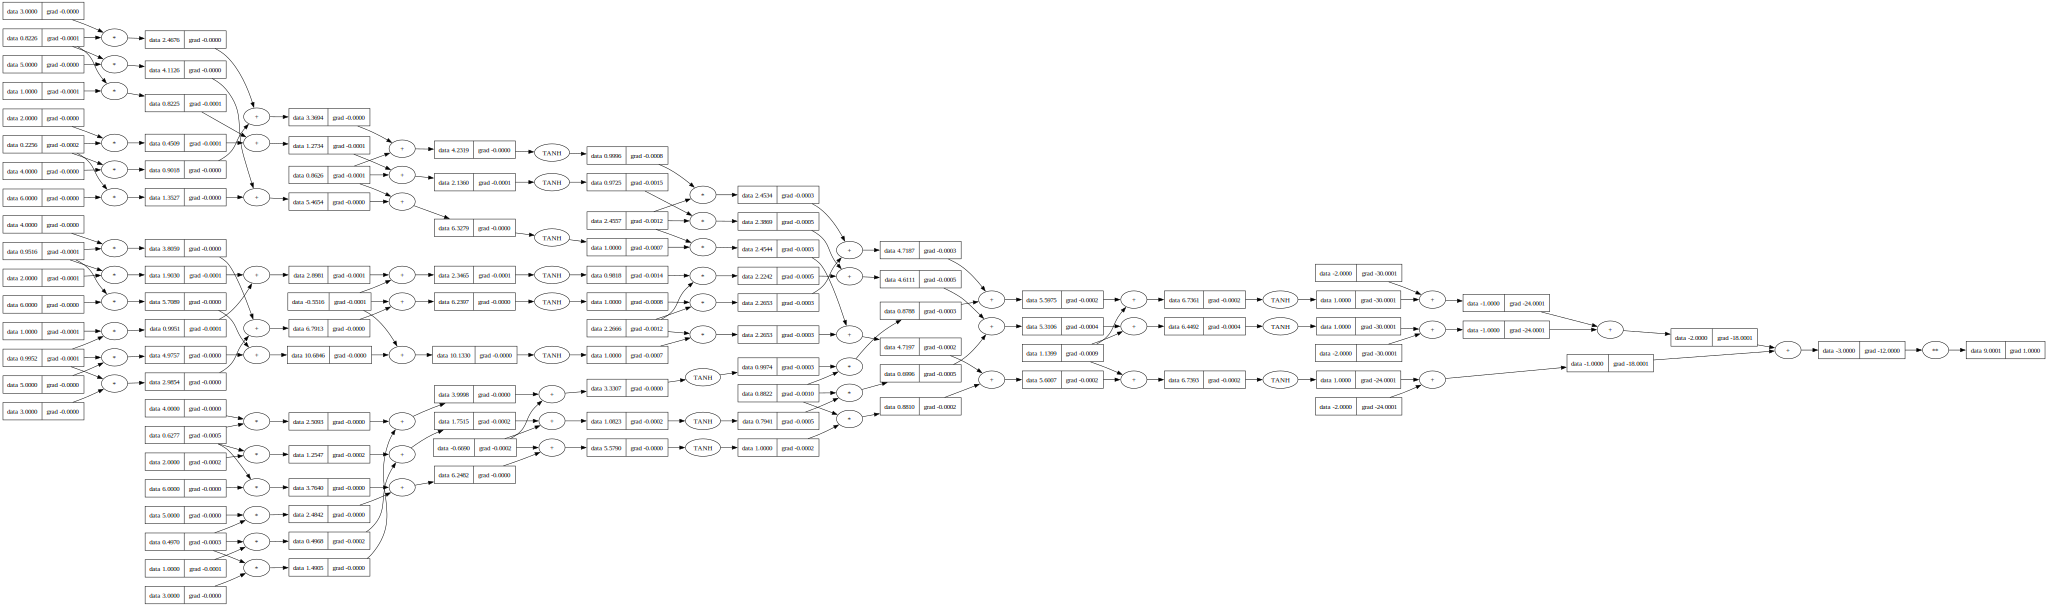

In [219]:
loss.backward()
draw_dot(loss)